## Feature Engineering Exercises

-----

<h4>Do your work for this exercise in a jupyter notebook named feature_engineering within the regression-exercises repo. Add, commit, and push your work.</h4>

-----

- Load the tips dataset. <b>complete</b>

- Create a column named tip_percentage. This should be the tip amount divided by the total bill. <b>complete</b>
- Create a column named price_per_person. This should be the total bill divided by the party size. <b>complete</b>
- Before using any of the methods discussed in the lesson, which features do you think would be most important for predicting the tip amount? The tip percentage? <b>complete</b>
- Use all the other numeric features to predict tip amount. Use select k best and recursive feature elimination to select the top 2 features. What are they? <b>complete</b>
- Use all the other numeric features to predict tip percentage. Use select k best and recursive feature elimination to select the top 2 features. What are they? <b>complete</b>
- Why do you think select k best and recursive feature elimination might give different answers for the top features? Does this change as you change the number of features your are selecting? <b>thinking on this one</b>
- Write a function named select_kbest that takes in the predictors (X), the target (y), and the number of features to select (k) and returns the names of the top k selected features based on the SelectKBest class. Test your function with the tips dataset. You should see the same results as when you did the process manually. <b>complete</b>

- Write a function named rfe that takes in the predictors, the target, and the number of features to select. It should return the top k features based on the RFE class. Test your function with the tips dataset. You should see the same results as when you did the process manually. <b>complete</b>

- Load the swiss dataset and use all the other features to predict Fertility. Find the top 3 features using both select k best and recursive feature elimination (use the functions you just built to help you out).

-----

In [1]:
# Load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 
import sklearn.preprocessing
from math import sqrt
import seaborn as sns
import warnings
import evaluate

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

from sklearn.feature_selection import SelectKBest, f_regression

from pydataset import data
warnings.filterwarnings('ignore')

In [2]:
df = sns.load_dataset('tips')

In [3]:
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


----

<h5> Create new columns </h5>

---

In [4]:
# Create tip_percentage 

df['tip_percentage'] = df['tip'] / df['total_bill']

In [5]:
# create price per person

df['price_per_person'] = df['total_bill'] / df['size']

In [6]:
df.head()

,total_bill,tip,sex,smoker,day,time,size,tip_percentage,price_per_person
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447,8.495000
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542,3.446667
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587,7.003333
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780,11.840000
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808,6.147500


In [7]:
df[['sex', 'smoker', 'day', 'time']] = df[['sex', 'smoker', 'day', 'time']].astype('object')

----

<h5>Before using any of the methods discussed in the lesson, which features do you think would be most important for predicting the tip amount? The tip percentage?</h5>


<font color = 'red'>I would look at total_bill and size of table to determine tip amount.</font>

<font color = 'blue'>Tip percentage would be best determined by total bill and tip amount.</font>


----

----

<h5>Train the data</h5>

---

In [8]:
def get_object_cols(df):
    '''
    This function takes in a dataframe and identifies the columns that are object types
    and returns a list of those column names. 
    '''
    # create a mask of columns whether they are object type or not
    mask = np.array(df.dtypes == "object")

        
    # get a list of the column names that are objects (from the mask)
    object_cols = df.iloc[:, mask].columns.tolist()
    
    return object_cols

In [9]:
object_cols = get_object_cols(df)

In [10]:
object_cols

['sex', 'smoker', 'day', 'time']

In [11]:
def train_validate_test(df, target):
    '''
    this function takes in a dataframe and splits it into 3 samples, 
    a test, which is 20% of the entire dataframe, 
    a validate, which is 24% of the entire dataframe,
    and a train, which is 56% of the entire dataframe. 
    It then splits each of the 3 samples into a dataframe with independent variables
    and a series with the dependent, or target variable. 
    The function returns 3 dataframes and 3 series:
    X_train (df) & y_train (series), X_validate & y_validate, X_test & y_test. 
    '''
    # split df into test (20%) and train_validate (80%)
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)

    # split train_validate off into train (70% of 80% = 56%) and validate (30% of 80% = 24%)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

        
    # split train into X (dataframe, drop target) & y (series, keep target only)
    X_train = train.drop(columns=[target])
    y_train = train[target]
    
    # split validate into X (dataframe, drop target) & y (series, keep target only)
    X_validate = validate.drop(columns=[target])
    y_validate = validate[target]
    
    # split test into X (dataframe, drop target) & y (series, keep target only)
    X_test = test.drop(columns=[target])
    y_test = test[target]
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [12]:
X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(df, 'tip')

-----

<h5>Scale the data</h5>

-----

In [13]:
def get_numeric_X_cols(X_train, object_cols):
    '''
    takes in a dataframe and list of object column names
    and returns a list of all other columns names, the non-objects. 
    '''
    numeric_cols = [col for col in X_train.columns.values if col not in object_cols]
    
    return numeric_cols

In [14]:
numeric_cols = get_numeric_X_cols(X_train, object_cols)

In [15]:
def min_max_scale(X_train, X_validate, X_test, numeric_cols):
    '''
    this function takes in 3 dataframes with the same columns, 
    a list of numeric column names (because the scaler can only work with numeric columns),
    and fits a min-max scaler to the first dataframe and transforms all
    3 dataframes using that scaler. 
    it returns 3 dataframes with the same column names and scaled values. 
    '''
    # create the scaler object and fit it to X_train (i.e. identify min and max)
    # if copy = false, inplace row normalization happens and avoids a copy (if the input is already a numpy array).


    scaler = MinMaxScaler(copy=True).fit(X_train[numeric_cols])

    #scale X_train, X_validate, X_test using the mins and maxes stored in the scaler derived from X_train. 
    # 
    X_train_scaled_array = scaler.transform(X_train[numeric_cols])
    X_validate_scaled_array = scaler.transform(X_validate[numeric_cols])
    X_test_scaled_array = scaler.transform(X_test[numeric_cols])

    # convert arrays to dataframes
    X_train_scaled = pd.DataFrame(X_train_scaled_array, 
                                  columns=numeric_cols).\
                                  set_index([X_train.index.values])

    X_validate_scaled = pd.DataFrame(X_validate_scaled_array, 
                                     columns=numeric_cols).\
                                     set_index([X_validate.index.values])

    X_test_scaled = pd.DataFrame(X_test_scaled_array, 
                                 columns=numeric_cols).\
                                 set_index([X_test.index.values])

    
    return X_train_scaled, X_validate_scaled, X_test_scaled

In [23]:
X_train_scaled, X_validate_scaled, X_test_scaled = min_max_scale(X_train, X_validate, X_test, numeric_cols)

-------

<h5>Use all the other numeric features to predict tip amount. Use select k best and recursive feature elimination to select the top 2 features. What are they?</h5>

<font color = green><b>total_bill/size for KBest & total_bill/tip_percentage</b></font>

------

In [24]:
# parameters: f_regression stats test, give me 8 features
f_selector = SelectKBest(f_regression, k=2)

# find the top 8 X's correlated with y
f_selector.fit(X_train_scaled, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

In [25]:
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [26]:
f_feature

['total_bill', 'size']

<h4>Recursive Feature Elimination</h4>

<AxesSubplot:xlabel='total_bill', ylabel='tip'>

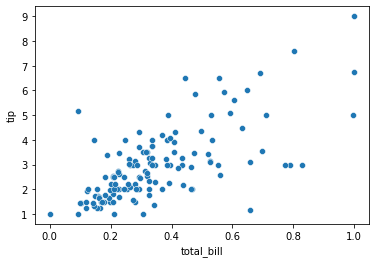

In [27]:
import seaborn as sns
sns.scatterplot(x="total_bill", y=y_train, data=X_train_scaled)

In [28]:
lm = LinearRegression()

In [29]:
rfe = RFE(lm, 2) # change 2 to k in function (x is df and y is target) def fun(x, y, k)

In [30]:
# Transforming data using RFE
X_rfe = rfe.fit_transform(X_train_scaled,y_train)  

In [31]:
#Fitting the data to model
lm.fit(X_rfe,y_train)

LinearRegression()

In [32]:
mask = rfe.support_

In [33]:
rfe_features = X_train_scaled.loc[:,mask].columns.tolist()

In [34]:
print(str(len(rfe_features)), 'selected features')
print(rfe_features)

2 selected features
['total_bill', 'tip_percentage']


In [35]:
var_ranks = rfe.ranking_
var_names = X_train_scaled.columns.tolist()

pd.DataFrame({'Var': var_names, 'Rank': var_ranks})

,Var,Rank
0,total_bill,1
1,size,2
2,tip_percentage,1
3,price_per_person,3


-------

-------

<h5>Use all the other numeric features to predict tip percentage. Use select k best and recursive feature elimination to select the top 2 features. What are they?</h5>


<font color = green><b>tip/price_per_person for KBest & total_bill/tip</b></font>

--------

In [36]:
X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(df, 'tip_percentage')

In [37]:
numeric_cols = get_numeric_X_cols(X_train, object_cols)

In [38]:
X_train_scaled, X_validate_scaled, X_test_scaled = min_max_scale(X_train, X_validate, X_test, numeric_cols)

In [39]:
# parameters: f_regression stats test, give me 8 features
f_selector = SelectKBest(f_regression, k=2)

# find the top 8 X's correlated with y
f_selector.fit(X_train_scaled, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

In [40]:
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [41]:
f_feature

['tip', 'price_per_person']

In [42]:
# Transforming data using RFE
X_rfe = rfe.fit_transform(X_train_scaled,y_train)  

In [43]:
#Fitting the data to model
lm.fit(X_rfe,y_train)

LinearRegression()

In [44]:
mask = rfe.support_

In [45]:
rfe_features = X_train_scaled.loc[:,mask].columns.tolist()

In [46]:
print(str(len(rfe_features)), 'selected features')
print(rfe_features)

2 selected features
['total_bill', 'tip']


In [47]:
var_ranks = rfe.ranking_
var_names = X_train_scaled.columns.tolist()

pd.DataFrame({'Var': var_names, 'Rank': var_ranks})

,Var,Rank
0,total_bill,1
1,tip,1
2,size,2
3,price_per_person,3


------

<h4>Write a function named select_kbest that takes in the predictors (X), the target (y), and the number of features to select (k) and returns the names of the top k selected features based on the SelectKBest class. Test your function with the tips dataset. You should see the same results as when you did the process manually.</h4>

-----

In [17]:
def select_kbest(x, y, k):
    
    # parameters: f_regression stats test, give me 8 features
    f_selector = SelectKBest(f_regression, k)
    
    # find the top 8 X's correlated with y
    f_selector.fit(X_train_scaled, y_train)
    
    # boolean mask of whether the column was selected or not. 
    feature_mask = f_selector.get_support()
    
    f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()
    
    return f_feature


In [21]:
select_kbest(X_train_scaled, 'tip', 2)

['total_bill', 'size']

-------

<h4>Write a function named rfe that takes in the predictors, the target, and the number of features to select. It should return the top k features based on the RFE class. Test your function with the tips dataset. You should see the same results as when you did the process manually.</h4>

------

In [19]:
def rfe(x, y, k):
    
    lm = LinearRegression()
    
    rfe = RFE(lm, k)
    
    # Transforming data using RFE
    X_rfe = rfe.fit_transform(X_train_scaled,y_train)  
    
    mask = rfe.support_
    
    rfe_features = X_train_scaled.loc[:,mask].columns.tolist()
    
    print(str(len(rfe_features)), 'selected features')
    
    return  rfe_features


In [22]:
rfe(X_train_scaled, 'tip', 2)

2 selected features


['total_bill', 'tip_percentage']